## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
import errno

# create directory
def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

save_directory = '../calibration_data/'
save_file_name = 'calibration_points_pickle.p'
file_path = save_directory + save_file_name
mkdir(save_directory)
# save camera calibration parameters
def saveCaliborationParameters():

    # prepare object points
    objectPoint = np.zeros((6*9,3), np.float32)
    objectPoint[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # arrays to store object points and images points
    objectPoints = []
    imagePoints =[]

    # make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # search cheseboard corners
    for index, fileName in enumerate(images):
        image = cv2.imread(fileName)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # find corners in cheseboard
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objectPoints.append(objectPoint)
            imagePoints.append(corners)

            # # draw and display the corners
            # imageWithCorners = cv2.drawCheseboardCorners(img, (9,6), corners, ret)
            # cv2.imshow(imageWithCorners)
            # cv2.waitKey(500)

    cv2.destroyAllWindows()

    # save objectPoints and imagePoints into pickle
    dist_pickle = {}
    image = cv2.imread('../camera_cal/calibration1.jpg')
    image_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, image_size, None, None)
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist

    file_path = os.path.join(save_directory, save_file_name)
    pickle.dump(dist_pickle, open(file_path, 'wb'))


# save corners points
saveCaliborationParameters()

# read saved parameters
dist_pickle = pickle.load(open(file_path, 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

def calibration_undistort(image):
    image_size = (image.shape[1], image.shape[0])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    return undistort

# output images directory
output_path = '../output_images/'

# undistort example cheseboard image
def testCalibration(image):
    undistort_image = calibration_undistort(image)

    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Orignal Image', fontsize=50)
    ax2.imshow(undistort_image)
    ax2.set_title('undistort Image', fontsize=50)
    plt.savefig(output_path + 'distort_image.jpg')


## Test cheseboard image

In [2]:
# test calibration
image_calibration = cv2.imread('../camera_cal/calibration1.jpg')
testCalibration(image_calibration)

## Test road image transform

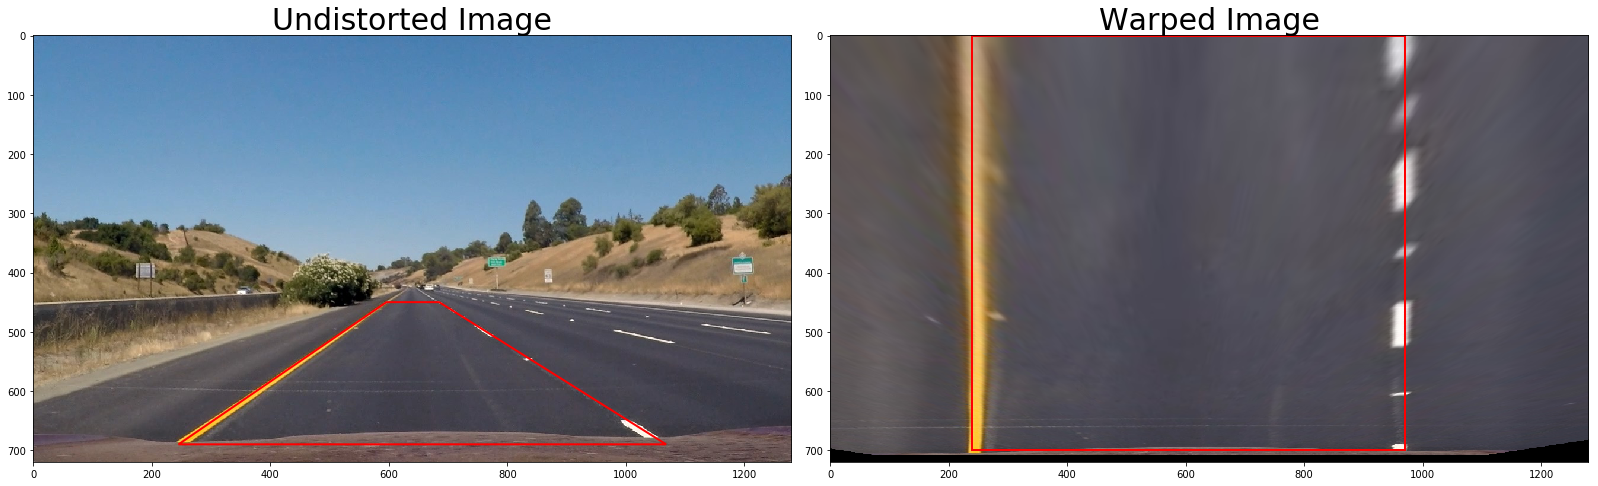

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
%matplotlib inline

source_points = np.float32([[245, 690],[596, 450], [685, 450], [1068, 690]])
dest_points = np.float32([[240, 700], [240, 0], [970, 0], [970, 700]])

def warpImage(image):
    image_size = (image.shape[1], image.shape[0])
    minV = cv2.getPerspectiveTransform(dest_points, source_points)
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return (warped, minV)

image_straight_lines = mpimg.imread('../test_images/straight_lines1.jpg')

undistort_image = calibration_undistort(image_straight_lines)
warped_image, minV = warpImage(undistort_image)

# draw distort and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_straight_lines)
ax1.add_patch(patches.Polygon(xy=source_points, fill=False, color='r', linewidth=2))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped_image)
ax2.add_patch(patches.Polygon(xy=dest_points, fill=False, color='r', linewidth=2))
ax2.set_title('Warped Image', fontsize=30)
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
plt.savefig(output_path + 'warped_stright_line.jpg')


# Gradient threshhold methods

In [4]:
# sobel gradient methods
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    else:
        raise
    sobel_binary = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(sobel_binary)
    binary_output[(sobel_binary >= thresh[0]) & (sobel_binary <= thresh[1])] = 1
    return binary_output

def mag_sobel_thresh(img, sobel_kernel=3, thresh=(0,255)):
    abs_sobel_x = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    mag_sobel = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    mag_sobel_binary = np.uint8(255*mag_sobel/np.max(mag_sobel))
    sobel_binary = np.zeros_like(mag_sobel_binary)
    sobel_binary[(mag_sobel_binary >= thresh[0]) & (mag_sobel_binary <= thresh[1])] = 1
    return sobel_binary

def dir_sobel_thresh(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    abs_sobel_x = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    sobel_direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    sobel_binary = np.zeros_like(sobel_direction)
    sobel_binary[(sobel_direction >= thresh[0]) & (sobel_direction <= thresh[1])] = 1
    return sobel_binary

# check HLS channel threshold method
def channel_thresh(img, channel = 's', thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 's':
        check_channel = hls[:,:,2]
    elif channel == 'h':
        check_channel = hls[:,:,0]
    elif channel == 'l':
        check_channel == hls[:,:,1]
    s_binary = np.zeros_like(check_channel)
    s_binary[(check_channel >= thresh[0]) & (check_channel <= thresh[1])] = 1
    return s_binary

# combined multiple sobel gradient methods 
def combined_thresh(img):
    image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_gradient_x = abs_sobel_thresh(image_gray, orient='x', sobel_kernel=3, thresh=(90,255))
    sobel_gradient_y = abs_sobel_thresh(image_gray, orient='y', sobel_kernel=3, thresh=(90,255))
    sobel_gradient_mag = mag_sobel_thresh(image_gray, sobel_kernel=3, thresh=(90, 255))
    sobel_gradient_dir = dir_sobel_thresh(image_gray, sobel_kernel=3, thresh=(np.pi/8, np.pi/2))

    binary_chanel_s = channel_thresh(img, channel = 's', thresh=(170, 255))

    combined_binary = np.zeros_like(sobel_gradient_dir)
    combined_binary[((sobel_gradient_x==1) & (sobel_gradient_y==1))|((sobel_gradient_mag==1) & (sobel_gradient_dir==1))|(binary_chanel_s==1)] = 1
    return combined_binary

# Test combined threshold method

In [5]:
# # draw binary combined image for test road image
# image_test = mpimg.imread('../test_images/test6.jpg')
# image_undistort = calibration_undistort(image_test)
# binary_image = combined_thresh(image_undistort)
# plt.imshow(binary_image, cmap='gray')
# plt.savefig(output_path + 'binary_combined_image.jpg')

# Define Line class to track line information

In [150]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        #polynomial average coefficients of the last n iterations
        self.best_fit = None
        #polynomial coefficients of the last n iterations
        self.recent_fits = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

# Implement Sliding Windows and Fit a Polynomial

In [299]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def initFrame(binary_warped):
    left_line = Line()
    right_line = Line()
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(np.int(histogram.shape[0]/2))
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    left_line.best_fit = left_fit
    right_line.best_fit = right_fit

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # init frame best fit set
    left_line.recent_fits.append(left_fit)
    left_line.recent_fits.append(right_fit)

    left_line.allx = left_fitx
    right_line.allx = right_fitx
    
    left_line.recent_xfitted.append(left_fitx)
    right_line.recent_xfitted.append(right_fitx)

    left_line.bestx = left_fitx
    right_line.bestx = right_fitx

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig(output_path + 'color_fit_line.jpg')
    left_line.detected = True
    right_line.detected = True
    return (out_img, left_line, right_line)


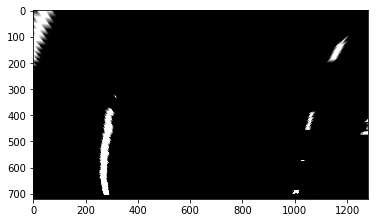

In [315]:
image_test = mpimg.imread('../test_images/test1.jpg')
# undistort image
image_undistort = calibration_undistort(image_test)
# convert to binary image using combined threshold
binary_image = combined_thresh(image_undistort)
# transform perspective of the image
warped_image, minV = warpImage(binary_image)
out_img, left_line, right_line = initFrame(warped_image.copy())
    

In [311]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
SMOTH_CONSTANCE_STEPS = 10

def processingFrame(binary_warped, previous_left_line, previous_right_line):
    left_line = Line()
    right_line = Line()
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (previous_left_line.current_fit[0]*(nonzeroy**2) + \
                     previous_left_line.current_fit[1]*nonzeroy + previous_left_line.current_fit[2] \
                     - margin)) & (nonzerox < (previous_left_line.current_fit[0]*(nonzeroy**2) + \
                     previous_left_line.current_fit[1]*nonzeroy + previous_left_line.current_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (previous_right_line.current_fit[0]*(nonzeroy**2) + \
                      previous_right_line.current_fit[1]*nonzeroy + previous_right_line.current_fit[2] \
                      - margin)) & (nonzerox < (previous_right_line.current_fit[0]*(nonzeroy**2) + \
                      previous_right_line.current_fit[1]*nonzeroy + previous_right_line.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    left_line.current_fit = left_fit
    right_fit = np.polyfit(righty, rightx, 2)
    right_line.current_fit = right_fit

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_line.allx = left_fitx
    right_line.allx = right_fitx
    # Caculate curvature
    y_eval = np.max(ploty)

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad

    vehicle_center_pixel = binary_warped.shape[1]/2
    ploty_max = np.max(ploty)
    left_bottom_x = left_fitx = left_fit[0]*ploty_max**2 + left_fit[1]*ploty_max + left_fit[2]
    right_bottom_x = right_fit[0]*ploty_max**2 + right_fit[1]*ploty_max + right_fit[2]

    left_line.line_base_pos = (vehicle_center_pixel - left_bottom_x) * xm_per_pix
    right_line.line_base_pos = (right_bottom_x - vehicle_center_pixel) * xm_per_pix

    # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     out_img = out_img.astype(np.uint8)
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                                   ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                                   ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    #plt.imshow(result)
    #plt.savefig(output_path + 'color_fit_line2.jpg')
    left_line.detected = True
    right_line.detected = True
    return (left_line, right_line)

def draw_lanes_section(binary_warped, left_line, right_line):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_line.allx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.allx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

def draw_into_original_image(image_undistort, color_warp, minV, image_size):
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, minV, image_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(image_undistort, 1, newwarp, 0.3, 0)
    return result

def write_text(result_image, current_left_line, current_right_line):
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature_left_text = "Left Curvature:" + format(current_left_line.radius_of_curvature, '.2f') + "    "
    to_left_text = "To Left:" + format(current_left_line.line_base_pos, '.2f')
    curvature_right_text = "Right Curvature:" + format(current_right_line.radius_of_curvature, '.2f') + "  "
    to_right_text = "To Right:" + format(current_right_line.line_base_pos, '.2f')
    cv2.putText(result_image, curvature_left_text + to_left_text, (10,100), font, 2, (255,255,255))
    cv2.putText(result_image, curvature_right_text + to_right_text, (10,200), font, 2, (255,255,255))
    return result_image

def smoth_sanity_check(previous_line, current_line):
    current_line.recent_xfitted = previous_line.recent_xfitted.copy()
    current_line.recent_fits = previous_line.recent_fits.copy()
    if len(current_line.recent_xfitted) >= SMOTH_CONSTANCE_STEPS:
        current_line.recent_xfitted.pop(0)
    if len(current_line.recent_fits) >= SMOTH_CONSTANCE_STEPS:
        current_line.recent_fits.pop(0)

    if current_line.radius_of_curvature > 300:
        current_line.recent_fits.append(current_line.current_fit)
        current_line.best_fit = apply_filter(current_line.recent_fits)
    else:
        current_line.current_fit = previous_line.best_fit
        current_line.best_fit = previous_line.best_fit
    if current_line.line_base_pos > 1.6 and current_line.line_base_pos < 2.6:
        current_line.recent_xfitted.append(current_line.allx)
        # using average of x values for last N steps
        current_line.bestx = apply_filter(current_line.recent_xfitted)
    else:
        current_line.allx = previous_line.bestx
        current_line.bestx = previous_line.bestx
    return current_line
def apply_filter(src_list):
    size = len(src_list)
    base = size*(size+1)/2
    factors = np.array(list(range(1,size+1)))/base
    return np.dot(factors, src_list) 
    
    
first_frame_detected = False
current_left_line = None
current_right_line = None
def image_frame_process(raw_image):
    # Undistort image
    global first_frame_detected, current_left_line, current_right_line
    image_size = (raw_image.shape[1], raw_image.shape[0])
    image_undistort = calibration_undistort(raw_image)
    binary_image = combined_thresh(image_undistort)
    # warp detected image
    binary_warped, minV = warpImage(binary_image)
    if first_frame_detected == False:
        out_img, current_left_line, current_right_line = initFrame(binary_warped)
        first_frame_detected = True
        return out_img
    else:
        left_line, right_line = processingFrame(binary_warped, current_left_line, current_right_line)
        current_left_line = smoth_sanity_check(current_left_line, left_line)
        current_right_line = smoth_sanity_check(current_right_line, right_line)
        color_warp = draw_lanes_section(binary_warped, current_left_line, current_right_line)
        result_image = draw_into_original_image(image_undistort, color_warp, minV, image_size)
        result = write_text(result_image, current_left_line, current_right_line)
        return result_image


# Video process pineline

In [312]:
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = '../videos_output/project_video8.mp4'
mkdir('../videos_output')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("../project_video.mp4")
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(image_frame_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../videos_output/project_video8.mp4
[MoviePy] Writing video ../videos_output/project_video8.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

3
2
1
2



  0%|          | 2/1261 [00:00<04:20,  4.83it/s]

4
3
2
3
5
4
3
4



  0%|          | 4/1261 [00:00<04:13,  4.96it/s]

6
5
4
5
7
6
6



  0%|          | 6/1261 [00:01<04:06,  5.08it/s]

8
7
7
9
8
5
8



  1%|          | 8/1261 [00:01<04:06,  5.08it/s]

10
9
6
9
10
10
7
10



  1%|          | 10/1261 [00:01<04:08,  5.04it/s]

10
10
8
10
10
10
9
10



  1%|          | 12/1261 [00:02<04:07,  5.05it/s]

10
10
10
10
10
10
10
10



  1%|          | 14/1261 [00:02<04:07,  5.04it/s]

10
10
10
10
10
10
10
10



  1%|▏         | 16/1261 [00:03<04:07,  5.04it/s]

10
10
10
10
10
10
10



  1%|▏         | 18/1261 [00:03<04:05,  5.05it/s]

10
10
10
10
10
10
10
10



  2%|▏         | 20/1261 [00:03<04:00,  5.16it/s]

10
10
10
10
10
10
10
10



  2%|▏         | 22/1261 [00:04<04:01,  5.13it/s]

10
10
10
10
10
10
10



  2%|▏         | 24/1261 [00:04<03:57,  5.21it/s]

10
10
10
10
10
10
10
10



  2%|▏         | 26/1261 [00:05<04:00,  5.14it/s]

10
10
10
10
10
10
10
10



  2%|▏         | 28/1261 [00:05<03:57,  5.20it/s]

10
10
10
10
10
10
10
10



  2%|▏         | 30/1261 [00:05<03:54,  5.25it/s]

10
10
10
10
10
10
10



  3%|▎         | 32/1261 [00:06<03:55,  5.22it/s]

10
10
10
10



  3%|▎         | 34/1261 [00:06<03:52,  5.27it/s]

10
10
10
10
10
10



  3%|▎         | 36/1261 [00:07<03:54,  5.23it/s]

10
10
10
10
10
10



  3%|▎         | 38/1261 [00:07<03:53,  5.23it/s]

10
10
10
10
10



  3%|▎         | 40/1261 [00:07<03:53,  5.23it/s]

10
10
10
10
10



  3%|▎         | 42/1261 [00:08<03:53,  5.22it/s]

10
10
10
10



  3%|▎         | 44/1261 [00:08<03:51,  5.26it/s]

10
10
10
10
10



  4%|▎         | 46/1261 [00:08<03:51,  5.25it/s]

10
10
10
10
10
10
10



  4%|▍         | 48/1261 [00:09<03:54,  5.18it/s]

10
10
10
10
10
10
10
10



  4%|▍         | 50/1261 [00:09<03:55,  5.14it/s]

10
10
10
10
10
10
10
10



  4%|▍         | 52/1261 [00:10<03:52,  5.20it/s]

10
10
10
10
10
10
10



  4%|▍         | 54/1261 [00:10<03:50,  5.23it/s]

10
10
10
10
10
10



  4%|▍         | 56/1261 [00:10<03:49,  5.25it/s]

10
10
10
10
10
10
10



  5%|▍         | 58/1261 [00:11<03:51,  5.20it/s]

10
10
10
10
10
10
10
10



  5%|▍         | 60/1261 [00:11<03:54,  5.13it/s]

10
10
10
10



  5%|▍         | 61/1261 [00:11<04:00,  4.99it/s]

10
10
10
10
10
10
10



  5%|▍         | 63/1261 [00:12<03:58,  5.03it/s]

10
10
10
10
10
10



  5%|▌         | 65/1261 [00:12<03:56,  5.06it/s]

10
10
10
10
10
10



  5%|▌         | 67/1261 [00:13<03:55,  5.07it/s]

10
10
10
10
10


  5%|▌         | 69/1261 [00:13<03:54,  5.08it/s]


10
10
10
10
10
10
10
10
10
10
10



  6%|▌         | 71/1261 [00:13<03:50,  5.17it/s]

10
10
10
10
10
10
10
10



  6%|▌         | 73/1261 [00:14<03:49,  5.17it/s]

10
10
10
10
10
10
10
10



  6%|▌         | 75/1261 [00:14<03:49,  5.18it/s]

10
10
10
10
10
10
10



  6%|▌         | 77/1261 [00:14<03:55,  5.03it/s]

10
10
10
10
10
10
10
10



  6%|▋         | 79/1261 [00:15<03:51,  5.10it/s]

10
10
10
10
10
10
10



  6%|▋         | 81/1261 [00:15<03:53,  5.05it/s]

10
10
10
10
10
10



  7%|▋         | 83/1261 [00:16<03:49,  5.14it/s]

10
10
10
10
10
10
10



  7%|▋         | 85/1261 [00:16<03:42,  5.28it/s]

10
10
10
10
10
10
10
10



  7%|▋         | 87/1261 [00:16<03:46,  5.18it/s]

10
10
10
10
10
10
10
10



  7%|▋         | 89/1261 [00:17<03:49,  5.10it/s]

10
10
10



  7%|▋         | 90/1261 [00:17<03:52,  5.04it/s]

10
10
10



  7%|▋         | 91/1261 [00:17<03:54,  4.99it/s]

10
10
10
10
10
10



  7%|▋         | 93/1261 [00:18<03:49,  5.09it/s]

10
10
10
10
10
10
10
10



  8%|▊         | 95/1261 [00:18<03:45,  5.17it/s]

10
10
10
10
10
10
10
10



  8%|▊         | 97/1261 [00:18<03:43,  5.21it/s]

10
10
10
10
10
10
10
10



  8%|▊         | 99/1261 [00:19<03:43,  5.20it/s]

10
10
10
10
10
10
10
10



  8%|▊         | 101/1261 [00:19<03:43,  5.19it/s]

10
10
10
10
10
10
10



  8%|▊         | 103/1261 [00:19<03:43,  5.18it/s]

10
10
10
10
10
10



  8%|▊         | 105/1261 [00:20<03:43,  5.17it/s]

10
10
10
10
10
10



  8%|▊         | 107/1261 [00:20<03:40,  5.23it/s]

10
10
10
10
10
10



  9%|▊         | 109/1261 [00:21<03:41,  5.19it/s]

10
10
10
10
10
10
10



  9%|▉         | 111/1261 [00:21<03:39,  5.24it/s]

10
10
10
10
10
10
10
10



  9%|▉         | 113/1261 [00:21<03:40,  5.21it/s]

10
10
10
10
10
10
10
10



  9%|▉         | 115/1261 [00:22<03:40,  5.19it/s]

10
10
10
10



  9%|▉         | 117/1261 [00:22<03:41,  5.17it/s]

10
10
10
10



  9%|▉         | 119/1261 [00:23<03:39,  5.20it/s]

10
10
10
10
10



 10%|▉         | 121/1261 [00:23<03:42,  5.13it/s]

10
10
10
10
10
10
10



 10%|▉         | 123/1261 [00:23<03:40,  5.16it/s]

10
10
10
10
10



 10%|▉         | 125/1261 [00:24<03:37,  5.21it/s]

10
10
10
10
10



 10%|█         | 127/1261 [00:24<03:36,  5.24it/s]

10
10
10
10
10
10



 10%|█         | 129/1261 [00:24<03:37,  5.20it/s]

10
10
10
10
10
10



 10%|█         | 131/1261 [00:25<03:35,  5.23it/s]

10
10
10
10
10
10
10
10



 11%|█         | 133/1261 [00:25<03:36,  5.21it/s]

10
10
10
10
10
10
10
10



 11%|█         | 135/1261 [00:26<03:35,  5.22it/s]

10
10
10
10
10
10
10
10



 11%|█         | 137/1261 [00:26<03:36,  5.20it/s]

10
10
10
10
10
10
10
10



 11%|█         | 139/1261 [00:26<03:35,  5.20it/s]

10
10
10
10
10
10
10
10



 11%|█         | 141/1261 [00:27<03:34,  5.22it/s]

10
10
10
10
10
10
10



 11%|█▏        | 143/1261 [00:27<03:36,  5.16it/s]

10
10
10
10
10
10
10



 11%|█▏        | 145/1261 [00:28<03:34,  5.19it/s]

10
10
10
10
10
10
10
10



 12%|█▏        | 147/1261 [00:28<03:35,  5.17it/s]

10
10
10
10
10
10
10
10



 12%|█▏        | 149/1261 [00:28<03:35,  5.17it/s]

10
10
10
10
10
10



 12%|█▏        | 151/1261 [00:29<03:38,  5.09it/s]

10
10
10
10
10
10



 12%|█▏        | 153/1261 [00:29<03:37,  5.10it/s]

10
10
10
10
10
10



 12%|█▏        | 155/1261 [00:29<03:32,  5.21it/s]

10
10
10
10
10
10



 12%|█▏        | 157/1261 [00:30<03:30,  5.25it/s]

10
10
10
10
10
10
10
10



 13%|█▎        | 159/1261 [00:30<03:30,  5.23it/s]

10
10
10
10
10
10
10
10



 13%|█▎        | 161/1261 [00:31<03:31,  5.20it/s]

10
10
10
10
10
10
10
10



 13%|█▎        | 163/1261 [00:31<03:31,  5.18it/s]

10
10
10
10
10
10
10
10



 13%|█▎        | 165/1261 [00:31<03:30,  5.20it/s]

10
10
10
10
10
10



 13%|█▎        | 167/1261 [00:32<03:30,  5.19it/s]

10
10
10
10
10
10



 13%|█▎        | 169/1261 [00:32<03:29,  5.22it/s]

10
10
10
10
10
10



 14%|█▎        | 171/1261 [00:33<03:28,  5.22it/s]

10
10
10
10
10
10



 14%|█▎        | 173/1261 [00:33<03:30,  5.17it/s]

10
10
10
10



 14%|█▍        | 175/1261 [00:33<03:29,  5.20it/s]

10
10
10
10
10
10
10
10



 14%|█▍        | 177/1261 [00:34<03:25,  5.28it/s]

10
10
10
10
10
10



 14%|█▍        | 179/1261 [00:34<03:26,  5.25it/s]

10
10
10
10
10
10



 14%|█▍        | 181/1261 [00:34<03:29,  5.17it/s]

10
10
10
10



 15%|█▍        | 183/1261 [00:35<03:31,  5.10it/s]

10
10
10
10
10
10



 15%|█▍        | 185/1261 [00:35<03:29,  5.14it/s]

10
10
10
10
10



 15%|█▍        | 187/1261 [00:36<03:22,  5.31it/s]

10
10
10
10
10



 15%|█▍        | 189/1261 [00:36<03:22,  5.30it/s]

10
10
10
10
10



 15%|█▌        | 191/1261 [00:36<03:22,  5.28it/s]

10
10
10
10



 15%|█▌        | 193/1261 [00:37<03:23,  5.25it/s]

10
10
10
10



 15%|█▌        | 195/1261 [00:37<03:24,  5.22it/s]

10
10
10
10
10
10



 16%|█▌        | 197/1261 [00:38<03:23,  5.24it/s]

10
10
10
10
10
10
10
10



 16%|█▌        | 199/1261 [00:38<03:22,  5.25it/s]

10
10
10
10
10
10



 16%|█▌        | 201/1261 [00:38<03:25,  5.17it/s]

10
10
10
10
10
10
10



 16%|█▌        | 203/1261 [00:39<03:23,  5.20it/s]

10
10
10
10
10
10
10
10



 16%|█▋        | 205/1261 [00:39<03:22,  5.21it/s]

10
10
10
10
10
10



 16%|█▋        | 207/1261 [00:39<03:23,  5.19it/s]

10
10
10
10
10
10



 17%|█▋        | 209/1261 [00:40<03:26,  5.09it/s]

10
10
10
10
10
10
10



 17%|█▋        | 211/1261 [00:40<03:25,  5.12it/s]

10
10
10
10
10
10
10
10



 17%|█▋        | 213/1261 [00:41<03:22,  5.18it/s]

10
10
10
10
10
10
10
10



 17%|█▋        | 215/1261 [00:41<03:19,  5.23it/s]

10
10
10
10
10
10



 17%|█▋        | 217/1261 [00:41<03:19,  5.23it/s]

10
10
10
10
10
10



 17%|█▋        | 219/1261 [00:42<03:19,  5.21it/s]

10
10
10
10
10
10
10
10



 18%|█▊        | 221/1261 [00:42<03:19,  5.21it/s]

10
10
10
10
10
10
10
10



 18%|█▊        | 223/1261 [00:43<03:18,  5.22it/s]

10
10
10
10
10
10
10
10



 18%|█▊        | 225/1261 [00:43<03:19,  5.20it/s]

10
10
10
10
10
10
10



 18%|█▊        | 227/1261 [00:43<03:17,  5.22it/s]

10
10
10
10
10
10



 18%|█▊        | 229/1261 [00:44<03:18,  5.20it/s]

10
10
10
10
10
10



 18%|█▊        | 231/1261 [00:44<03:22,  5.08it/s]

10
10
10
10
10
10



 18%|█▊        | 233/1261 [00:44<03:20,  5.13it/s]

10
10
10
10
10
10
10
10



 19%|█▊        | 235/1261 [00:45<03:21,  5.10it/s]

10
10
10
10
10
10
10



 19%|█▉        | 237/1261 [00:45<03:23,  5.03it/s]

10
10
10
10
10
10



 19%|█▉        | 239/1261 [00:46<03:20,  5.09it/s]

10
10
10
10
10
10



 19%|█▉        | 241/1261 [00:46<03:19,  5.11it/s]

10
10
10
10


 19%|█▉        | 243/1261 [00:46<03:19,  5.11it/s]


10
10
10
10
10
10
10
10
10
10



 19%|█▉        | 245/1261 [00:47<03:15,  5.19it/s]

10
10
10
10
10
10
10



 20%|█▉        | 247/1261 [00:47<03:14,  5.21it/s]

10
10
10
10
10



 20%|█▉        | 249/1261 [00:48<03:12,  5.27it/s]

10
10
10
10
10
10



 20%|█▉        | 251/1261 [00:48<03:12,  5.24it/s]

10
10
10
10
10
10



 20%|██        | 253/1261 [00:48<03:10,  5.28it/s]

10
10
10
10
10
10



 20%|██        | 255/1261 [00:49<03:11,  5.24it/s]

10
10
10
10
10
10
10
10



 20%|██        | 257/1261 [00:49<03:11,  5.24it/s]

10
10
10
10
10
10



 21%|██        | 259/1261 [00:49<03:11,  5.23it/s]

10
10
10
10
10
10



 21%|██        | 261/1261 [00:50<03:12,  5.20it/s]

10
10
10



 21%|██        | 262/1261 [00:50<03:17,  5.05it/s]

10
10
10
10
10
10



 21%|██        | 264/1261 [00:50<03:13,  5.16it/s]

10
10
10
10
10
10



 21%|██        | 266/1261 [00:51<03:11,  5.20it/s]

10
10
10
10
10
10
10



 21%|██▏       | 268/1261 [00:51<03:12,  5.15it/s]

10
10
10
10
10
10
10
10



 21%|██▏       | 270/1261 [00:52<03:09,  5.23it/s]

10
10
10
10
10
10
10
10



 22%|██▏       | 272/1261 [00:52<03:09,  5.23it/s]

10
10
10
10
10
10
10



 22%|██▏       | 274/1261 [00:52<03:07,  5.26it/s]

10
10
10
10
10
10
10
10



 22%|██▏       | 276/1261 [00:53<03:10,  5.17it/s]

10
10
10
10
10
10
10
10



 22%|██▏       | 278/1261 [00:53<03:10,  5.15it/s]

10
10
10
10



 22%|██▏       | 279/1261 [00:53<03:17,  4.96it/s]

10
10
10
10



 22%|██▏       | 280/1261 [00:54<03:19,  4.93it/s]

10
10
10
10



 22%|██▏       | 281/1261 [00:54<03:19,  4.92it/s]

10
10
10
10
10


 22%|██▏       | 283/1261 [00:54<03:14,  5.02it/s]


10
10
10
10
10
10
10
10
10
10
10



 23%|██▎       | 285/1261 [00:55<03:10,  5.12it/s]

10
10
10
10
10
10
10
10



 23%|██▎       | 287/1261 [00:55<03:09,  5.15it/s]

10
10
10
10
10
10
10
10



 23%|██▎       | 289/1261 [00:55<03:08,  5.16it/s]

10
10
10
10
10
10
10
10



 23%|██▎       | 291/1261 [00:56<03:07,  5.17it/s]

10
10
10
10
10
10
10
10



 23%|██▎       | 293/1261 [00:56<03:08,  5.15it/s]

10
10
10
10
10
10
10
10



 23%|██▎       | 295/1261 [00:56<03:07,  5.15it/s]

10
10
10
10
10
10
10
10



 24%|██▎       | 297/1261 [00:57<03:06,  5.16it/s]

10
10
10
10
10
10
10
10



 24%|██▎       | 299/1261 [00:57<03:06,  5.16it/s]

10
10
10
10
10
10
10
10



 24%|██▍       | 301/1261 [00:58<03:08,  5.08it/s]

10
10
10
10
10
10
10
10



 24%|██▍       | 303/1261 [00:58<03:13,  4.96it/s]

10
10
10
10



 24%|██▍       | 304/1261 [00:58<03:15,  4.89it/s]

10
10
10
10
10
10
10



 24%|██▍       | 306/1261 [00:59<03:12,  4.96it/s]

10
10
10
10
10
10
10
10
10



 24%|██▍       | 308/1261 [00:59<03:08,  5.05it/s]

10
10
10
10
10
10
10
10



 25%|██▍       | 310/1261 [00:59<03:05,  5.12it/s]

10
10
10
10
10
10
10
10



 25%|██▍       | 312/1261 [01:00<03:02,  5.20it/s]

10
10
10
10
10
10
10
10



 25%|██▍       | 314/1261 [01:00<03:01,  5.23it/s]

10
10
10
10
10
10
10
10



 25%|██▌       | 316/1261 [01:01<02:59,  5.25it/s]

10
10
10
10
10
10
10
10



 25%|██▌       | 318/1261 [01:01<03:01,  5.20it/s]

10
10
10
10
10
10
10
10



 25%|██▌       | 320/1261 [01:01<03:00,  5.20it/s]

10
10
10
10
10
10
10
10



 26%|██▌       | 322/1261 [01:02<03:04,  5.08it/s]

10
10
10
10
10
10
10
10



 26%|██▌       | 324/1261 [01:02<03:02,  5.14it/s]

10
10
10
10
10
10
10
10



 26%|██▌       | 326/1261 [01:03<03:00,  5.18it/s]

10
10
10
10
10
10
10
10



 26%|██▌       | 328/1261 [01:03<03:00,  5.17it/s]

10
10
10
10
10
10
10
10



 26%|██▌       | 330/1261 [01:03<03:01,  5.14it/s]

10
10
10
10



 26%|██▌       | 331/1261 [01:04<03:06,  5.00it/s]

10
10
10
10
10


 26%|██▋       | 333/1261 [01:04<03:03,  5.05it/s]


10
10
10
10
10
10
10
10
10
10
10



 27%|██▋       | 335/1261 [01:04<03:01,  5.10it/s]

10
10
10
10
10
10
10
10



 27%|██▋       | 337/1261 [01:05<02:59,  5.15it/s]

10
10
10
10
10
10
10
10



 27%|██▋       | 339/1261 [01:05<02:59,  5.15it/s]

10
10
10
10
10
10
10
10



 27%|██▋       | 341/1261 [01:05<03:02,  5.05it/s]

10
10
10
10



 27%|██▋       | 342/1261 [01:06<03:05,  4.95it/s]

10
10
10
10
10
10
10
10



 27%|██▋       | 344/1261 [01:06<03:02,  5.04it/s]

10
10
10
10
10
10
10
10



 27%|██▋       | 346/1261 [01:06<03:01,  5.04it/s]

10
10
10
10
10
10
10
10



 28%|██▊       | 348/1261 [01:07<02:59,  5.09it/s]

10
10
10
10
10
10
10
10



 28%|██▊       | 350/1261 [01:07<02:59,  5.08it/s]

10
10
10
10
10
10
10
10



 28%|██▊       | 352/1261 [01:08<02:56,  5.15it/s]

10
10
10
10
10
10
10
10



 28%|██▊       | 354/1261 [01:08<02:55,  5.17it/s]

10
10
10
10
10
10
10
10



 28%|██▊       | 356/1261 [01:08<02:54,  5.19it/s]

10
10
10
10
10
10
10
10



 28%|██▊       | 358/1261 [01:09<02:54,  5.18it/s]

10
10
10
10
10
10
10
10



 29%|██▊       | 360/1261 [01:09<02:54,  5.18it/s]

10
10
10
10
10
10
10
10



 29%|██▊       | 362/1261 [01:10<02:54,  5.15it/s]

10
10
10
10
10
10
10
10



 29%|██▉       | 364/1261 [01:10<02:57,  5.05it/s]

10
10
10
10



 29%|██▉       | 365/1261 [01:10<03:00,  4.97it/s]

10
10
10
10



 29%|██▉       | 367/1261 [01:11<02:58,  5.02it/s]

10
10
10
10
10
10
10
10
10
10
10
10



 29%|██▉       | 369/1261 [01:11<02:53,  5.13it/s]

10
10
10
10
10
10
10
10



 29%|██▉       | 371/1261 [01:11<02:51,  5.19it/s]

10
10
10
10
10
10
10
10



 30%|██▉       | 373/1261 [01:12<02:51,  5.17it/s]

10
10
10
10
10
10
10
10



 30%|██▉       | 375/1261 [01:12<02:52,  5.14it/s]

10
10
10
10
10
10
10
10



 30%|██▉       | 377/1261 [01:12<02:48,  5.23it/s]

10
10
10
10
10
10
10
10



 30%|███       | 379/1261 [01:13<02:50,  5.18it/s]

10
10
10
10
10
10
10
10



 30%|███       | 381/1261 [01:13<02:49,  5.20it/s]

10
10
10
10
10


 30%|███       | 383/1261 [01:14<02:50,  5.16it/s]


10
10
10
10
10
10
10
10
10
10
10



 31%|███       | 385/1261 [01:14<02:48,  5.20it/s]

10
10
10
10
10
10
10
10



 31%|███       | 387/1261 [01:14<02:48,  5.18it/s]

10
10
10
10
10
10
10
10



 31%|███       | 389/1261 [01:15<02:49,  5.13it/s]

10
10
10
10
10
10
10
10



 31%|███       | 391/1261 [01:15<02:49,  5.12it/s]

10
10
10
10
10
10
10
10



 31%|███       | 393/1261 [01:16<02:49,  5.13it/s]

10
10
10
10
10
10
10
10



 31%|███▏      | 395/1261 [01:16<02:48,  5.15it/s]

10
10
10
10
10
10
10
10



 31%|███▏      | 397/1261 [01:16<02:52,  5.01it/s]

10
10
10
10
10
10
10
10



 32%|███▏      | 399/1261 [01:17<02:49,  5.09it/s]

10
10
10
10
10
10
10
10



 32%|███▏      | 401/1261 [01:17<02:46,  5.16it/s]

10
10
10
10
10
10
10
10



 32%|███▏      | 403/1261 [01:18<02:45,  5.19it/s]

10
10
10
10
10
10
10
10



 32%|███▏      | 405/1261 [01:18<02:43,  5.24it/s]

10
10
10
10
10
10
10
10



 32%|███▏      | 407/1261 [01:18<02:45,  5.17it/s]

10
10
10
10
10
10
10
10



 32%|███▏      | 409/1261 [01:19<02:45,  5.14it/s]

10
10
10
10
10
10
10
10



 33%|███▎      | 411/1261 [01:19<02:43,  5.21it/s]

10
10
10
10
10
10
10
10



 33%|███▎      | 413/1261 [01:19<02:41,  5.24it/s]

10
10
10
10
10
10
10
10



 33%|███▎      | 415/1261 [01:20<02:41,  5.22it/s]

10
10
10
10
10
10
10
10



 33%|███▎      | 417/1261 [01:20<02:42,  5.19it/s]

10
10
10
10
10
10
10
10



 33%|███▎      | 419/1261 [01:21<02:41,  5.21it/s]

10
10
10
10
10
10
10
10



 33%|███▎      | 421/1261 [01:21<02:43,  5.15it/s]

10
10
10
10
10
10
10
10



 34%|███▎      | 423/1261 [01:21<02:43,  5.13it/s]

10
10
10
10



 34%|███▎      | 424/1261 [01:22<02:46,  5.04it/s]

10
10
10
10
10
10
10
10



 34%|███▍      | 426/1261 [01:22<02:43,  5.12it/s]

10
10
10
10
10
10
10
10



 34%|███▍      | 428/1261 [01:22<02:41,  5.14it/s]

10
10
10
10
10
10
10
10



 34%|███▍      | 430/1261 [01:23<02:41,  5.14it/s]

10
10
10
10
10
10
10
10



 34%|███▍      | 432/1261 [01:23<02:39,  5.19it/s]

10
10
10
10
10
10
10
10



 34%|███▍      | 434/1261 [01:24<02:39,  5.17it/s]

10
10
10
10



 34%|███▍      | 435/1261 [01:24<02:42,  5.07it/s]

10
10
10
10



 35%|███▍      | 436/1261 [01:24<02:43,  5.04it/s]

10
10
10
10
10
10
10
10



 35%|███▍      | 438/1261 [01:24<02:45,  4.99it/s]

10
10
10
10
10
10
10
10



 35%|███▍      | 440/1261 [01:25<02:43,  5.03it/s]

10
10
10
10
10
10
10
10



 35%|███▌      | 442/1261 [01:25<02:40,  5.10it/s]

10
10
10
10
10
10
10
10



 35%|███▌      | 444/1261 [01:26<02:38,  5.17it/s]

10
10
10
10
10
10
10
10



 35%|███▌      | 446/1261 [01:26<02:39,  5.10it/s]

10
10
10
10
10
10
10
10



 36%|███▌      | 448/1261 [01:26<02:38,  5.14it/s]

10
10
10
10
10
10
10
10



 36%|███▌      | 450/1261 [01:27<02:36,  5.19it/s]

10
10
10
10
10
10
10
10



 36%|███▌      | 453/1261 [01:27<02:34,  5.22it/s]

10
10
10
10
10
10
10
10



 36%|███▌      | 454/1261 [01:27<02:36,  5.16it/s]

10
10
10
10
10
10
10
10



 36%|███▌      | 456/1261 [01:28<02:34,  5.19it/s]

10
10
10
10
10
10
10
10



 36%|███▋      | 458/1261 [01:28<02:34,  5.19it/s]

10
10
10
10
10
10
10
10



 36%|███▋      | 460/1261 [01:29<02:36,  5.12it/s]

10
10
10
10
10
10
10
10



 37%|███▋      | 462/1261 [01:29<02:37,  5.06it/s]

10
10
10
10
10
10
10
10



 37%|███▋      | 464/1261 [01:29<02:37,  5.07it/s]

10
10
10
10
10
10
10
10



 37%|███▋      | 466/1261 [01:30<02:36,  5.10it/s]

10
10
10
10
10
10
10
10



 37%|███▋      | 468/1261 [01:30<02:31,  5.22it/s]

10
10
10
10
10
10
10
10



 37%|███▋      | 470/1261 [01:31<02:33,  5.16it/s]

10
10
10
10
10
10
10
10



 37%|███▋      | 472/1261 [01:31<02:31,  5.20it/s]

10
10
10
10
10
10
10
10



 38%|███▊      | 474/1261 [01:31<02:30,  5.24it/s]

10
10
10
10
10
10
10
10



 38%|███▊      | 476/1261 [01:32<02:31,  5.18it/s]

10
10
10
10
10
10
10
10



 38%|███▊      | 478/1261 [01:32<02:32,  5.15it/s]

10
10
10
10
10
10
10
10



 38%|███▊      | 480/1261 [01:32<02:30,  5.18it/s]

10
10
10
10
10
10
10
10



 38%|███▊      | 482/1261 [01:33<02:31,  5.13it/s]

10
10
10
10
10
10
10
10


 38%|███▊      | 484/1261 [01:33<02:30,  5.17it/s]


10
10
10
10
10
10
10
10



 39%|███▊      | 486/1261 [01:34<02:26,  5.31it/s]

10
10
10
10
10
10
10
10



 39%|███▊      | 488/1261 [01:34<02:29,  5.17it/s]

10
10
10
10
10
10
10
10



 39%|███▉      | 490/1261 [01:34<02:30,  5.13it/s]

10
10
10
10



 39%|███▉      | 491/1261 [01:35<02:33,  5.02it/s]

10
10
10
10
10
10
10



 39%|███▉      | 493/1261 [01:35<02:34,  4.99it/s]

10
10
10
10
10
10
10
10
10



 39%|███▉      | 495/1261 [01:35<02:30,  5.09it/s]

10
10
10
10
10
10
10
10



 39%|███▉      | 497/1261 [01:36<02:26,  5.20it/s]

10
10
10
10
10
10
10
10



 40%|███▉      | 499/1261 [01:36<02:27,  5.18it/s]

10
10
10
10
10
10
10
10



 40%|███▉      | 501/1261 [01:37<02:29,  5.07it/s]

10
10
10
10



 40%|███▉      | 503/1261 [01:37<02:29,  5.07it/s]

10
10
10
10
10
10
10
10
10
10
10
10



 40%|████      | 505/1261 [01:37<02:26,  5.16it/s]

10
10
10
10
10
10
10
10



 40%|████      | 507/1261 [01:38<02:30,  5.00it/s]

10
10
10
10
10
10
10
10



 40%|████      | 509/1261 [01:38<02:27,  5.11it/s]

10
10
10
10
10
10
10
10



 41%|████      | 511/1261 [01:39<02:25,  5.17it/s]

10
10
10
10
10
10
10
10



 41%|████      | 513/1261 [01:39<02:26,  5.12it/s]

10
10
10
10
10
10
10
10



 41%|████      | 515/1261 [01:39<02:27,  5.07it/s]

10
10
10
10
10


 41%|████      | 517/1261 [01:40<02:26,  5.07it/s]


10
10
10
10
10
10
10
10
10
10
10



 41%|████      | 519/1261 [01:40<02:28,  5.00it/s]

10
10
10
10
10


 41%|████▏     | 521/1261 [01:41<02:29,  4.95it/s]


10
10
10
10
10
10
10
10
10
10



 41%|████▏     | 523/1261 [01:41<02:27,  4.99it/s]

10
10
10
10
10
10
10
10



 42%|████▏     | 525/1261 [01:41<02:24,  5.10it/s]

10
10
10
10
10
10
10
10



 42%|████▏     | 527/1261 [01:42<02:21,  5.17it/s]

10
10
10
10
10
10
10
10



 42%|████▏     | 529/1261 [01:42<02:18,  5.27it/s]

10
10
10
10
10
10
10
10



 42%|████▏     | 532/1261 [01:43<02:14,  5.42it/s]

10
10
10
10
10
10
10
10



 42%|████▏     | 534/1261 [01:43<02:12,  5.49it/s]

10
10
10
10
10
10
10
10



 43%|████▎     | 536/1261 [01:43<02:10,  5.54it/s]

10
10
10
10
10
10
10
10



 43%|████▎     | 537/1261 [01:43<02:11,  5.52it/s]

10
10
10
10
10
10
10
10



 43%|████▎     | 540/1261 [01:44<02:09,  5.55it/s]

10
10
10
10
10
10
10
10



 43%|████▎     | 542/1261 [01:44<02:09,  5.54it/s]

10
10
10
10
10
10
10
10



 43%|████▎     | 544/1261 [01:45<02:09,  5.54it/s]

10
10
10
10
10
10
10
10



 43%|████▎     | 546/1261 [01:45<02:09,  5.52it/s]

10
10
10
10
10
10
10
10



 43%|████▎     | 548/1261 [01:45<02:07,  5.57it/s]

10
10
10
10
10
10
10
10



 44%|████▎     | 550/1261 [01:46<02:08,  5.53it/s]

10
10
10
10
10
10
10
10



 44%|████▍     | 552/1261 [01:46<02:08,  5.52it/s]

10
10
10
10
10
10
10
10



 44%|████▍     | 554/1261 [01:47<02:09,  5.47it/s]

10
10
10
10
10
10
10
10



 44%|████▍     | 556/1261 [01:47<02:06,  5.58it/s]

10
10
10
10
10
10
10
10



 44%|████▍     | 558/1261 [01:47<02:03,  5.69it/s]

10
10
10
10
10
10
10
10



 44%|████▍     | 560/1261 [01:48<02:03,  5.66it/s]

10
10
10
10
10
10
10



 45%|████▍     | 562/1261 [01:48<02:04,  5.63it/s]

10
10
10
10
10
10
10



 45%|████▍     | 564/1261 [01:48<02:02,  5.68it/s]

10
10
10
10
10
10
10
10



 45%|████▍     | 566/1261 [01:49<01:59,  5.81it/s]

10
10
10
10
10
10
10
10



 45%|████▌     | 568/1261 [01:49<01:58,  5.87it/s]

10
10
10
10
10
10
10
10



 45%|████▌     | 570/1261 [01:49<01:56,  5.91it/s]

10
10
10
10
10
10
10
10



 45%|████▌     | 572/1261 [01:50<01:59,  5.78it/s]

10
10
10
10
10
10
10
10



 46%|████▌     | 574/1261 [01:50<01:57,  5.87it/s]

10
10
10
10
10
10
10
10



 46%|████▌     | 576/1261 [01:50<01:55,  5.93it/s]

10
10
10
10
10
10
10
10



 46%|████▌     | 578/1261 [01:51<01:55,  5.90it/s]

10
10
10
10
10
10
10



 46%|████▌     | 580/1261 [01:51<01:55,  5.89it/s]

10
10
10
10
10
10
10
10



 46%|████▌     | 582/1261 [01:51<01:55,  5.90it/s]

10
10
10
10
10
10
10
10



 46%|████▋     | 584/1261 [01:52<01:54,  5.90it/s]

10
10
10
10
10
10
10
10



 46%|████▋     | 586/1261 [01:52<01:54,  5.90it/s]

10
10
10
10
10
10
10
10



 47%|████▋     | 588/1261 [01:52<01:55,  5.82it/s]

10
10
10
10
10
10
10
10



 47%|████▋     | 590/1261 [01:53<01:55,  5.80it/s]

10
10
10
10
10
10
10



 47%|████▋     | 592/1261 [01:53<01:55,  5.79it/s]

10
10
10
10
10
10
10
10



 47%|████▋     | 594/1261 [01:53<01:53,  5.85it/s]

10
10
10
10
10
10
10
10



 47%|████▋     | 596/1261 [01:54<01:52,  5.91it/s]

10
10
10
10
10
10
10
10



 47%|████▋     | 598/1261 [01:54<01:51,  5.93it/s]

10
10
10
10
10
10
10
10



 48%|████▊     | 600/1261 [01:54<01:54,  5.76it/s]

10
10
10
10
10
10
10



 48%|████▊     | 602/1261 [01:55<01:56,  5.65it/s]

10
10
10
10
10
10
10
10



 48%|████▊     | 604/1261 [01:55<01:56,  5.66it/s]

10
10
10
10
10
10
10



 48%|████▊     | 606/1261 [01:56<01:57,  5.59it/s]

10
10
10
10
10
10
10



 48%|████▊     | 608/1261 [01:56<01:56,  5.58it/s]

10
10
10
10
10
10



 48%|████▊     | 609/1261 [01:56<01:56,  5.59it/s]

10
10
10
10
10
10
10



 49%|████▊     | 612/1261 [01:57<01:54,  5.67it/s]

10
10
10
10
10
10
10



 49%|████▊     | 614/1261 [01:57<01:55,  5.61it/s]

10
10
10
10
10



 49%|████▉     | 616/1261 [01:57<01:54,  5.64it/s]

10
10
10
10
10



 49%|████▉     | 617/1261 [01:58<01:54,  5.61it/s]

10
10
10
10
10
10
10
10



 49%|████▉     | 619/1261 [01:58<01:57,  5.47it/s]

10
10
10
10
10
10
10



 49%|████▉     | 621/1261 [01:58<01:59,  5.35it/s]

10
10
10
10
10
10
10
10



 49%|████▉     | 623/1261 [01:59<01:58,  5.39it/s]

10
10
10
10
10
10
10
10



 50%|████▉     | 625/1261 [01:59<01:57,  5.40it/s]

10
10
10
10
10
10
10
10



 50%|████▉     | 627/1261 [01:59<01:57,  5.38it/s]

10
10
10
10
10
10
10
10



 50%|████▉     | 629/1261 [02:00<02:02,  5.17it/s]

10
10
10
10
10
10
10



 50%|█████     | 631/1261 [02:00<02:01,  5.21it/s]

10
10
10
10
10
10
10
10



 50%|█████     | 633/1261 [02:01<02:02,  5.11it/s]

10
10
10
10
10
10
10
10



 50%|█████     | 635/1261 [02:01<02:02,  5.09it/s]

10
10
10
10
10
10
10
10



 51%|█████     | 637/1261 [02:01<01:59,  5.21it/s]

10
10
10
10
10
10



 51%|█████     | 639/1261 [02:02<01:58,  5.25it/s]

10
10
10
10
10
10
10



 51%|█████     | 641/1261 [02:02<01:57,  5.29it/s]

10
10
10
10
10
10
10
10



 51%|█████     | 644/1261 [02:03<01:53,  5.42it/s]

10
10
10
10
10
10
10
10



 51%|█████     | 645/1261 [02:03<01:54,  5.39it/s]

10
10
10
10
10
10
10
10



 51%|█████▏    | 647/1261 [02:03<01:55,  5.32it/s]

10
10
10
10
10
10
10
10



 51%|█████▏    | 649/1261 [02:04<01:57,  5.21it/s]

10
10
10
10
10
10
10
10



 52%|█████▏    | 651/1261 [02:04<01:57,  5.18it/s]

10
10
10
10
10
10
10
10



 52%|█████▏    | 653/1261 [02:04<01:55,  5.26it/s]

10
10
10
10
10
10
10
10



 52%|█████▏    | 656/1261 [02:05<01:52,  5.36it/s]

10
10
10
10
10
10
10
10



 52%|█████▏    | 657/1261 [02:05<01:52,  5.35it/s]

10
10
10
10
10
10
10
10



 52%|█████▏    | 659/1261 [02:05<01:52,  5.36it/s]

10
10
10
10
10
10
10
10



 52%|█████▏    | 662/1261 [02:06<01:51,  5.39it/s]

10
10
10
10
10
10
10
10



 53%|█████▎    | 663/1261 [02:06<01:50,  5.42it/s]

10
10
10
10
10
10
10
10



 53%|█████▎    | 665/1261 [02:07<01:49,  5.42it/s]

10
10
10
10
10
10
10
10



 53%|█████▎    | 667/1261 [02:07<01:52,  5.30it/s]

10
10
10
10
10
10
10
10



 53%|█████▎    | 669/1261 [02:07<01:50,  5.37it/s]

10
10
10
10
10
10
10
10



 53%|█████▎    | 671/1261 [02:08<01:50,  5.34it/s]

10
10
10
10
10
10
10
10



 53%|█████▎    | 673/1261 [02:08<01:50,  5.34it/s]

10
10
10
10
10
10
10
10



 54%|█████▎    | 675/1261 [02:08<01:53,  5.18it/s]

10
10
10
10
10
10
10
10



 54%|█████▎    | 677/1261 [02:09<01:52,  5.20it/s]

10
10
10
10
10
10
10
10



 54%|█████▍    | 679/1261 [02:09<01:51,  5.21it/s]

10
10
10
10
10
10
10
10



 54%|█████▍    | 681/1261 [02:10<01:50,  5.23it/s]

10
10
10
10
10
10
10
10



 54%|█████▍    | 683/1261 [02:10<01:49,  5.27it/s]

10
10
10
10
10
10
10
10



 54%|█████▍    | 686/1261 [02:11<01:46,  5.42it/s]

10
10
10
10
10
10
10
10



 54%|█████▍    | 687/1261 [02:11<01:47,  5.35it/s]

10
10
10
10
10
10
10
10



 55%|█████▍    | 689/1261 [02:11<01:48,  5.28it/s]

10
10
10
10
10
10
10
10



 55%|█████▍    | 691/1261 [02:11<01:47,  5.31it/s]

10
10
10
10
10
10
10
10



 55%|█████▍    | 693/1261 [02:12<01:47,  5.26it/s]

10
10
10
10
10
10
10
10



 55%|█████▌    | 695/1261 [02:12<01:47,  5.28it/s]

10
10
10
10
10
10
10
10



 55%|█████▌    | 697/1261 [02:13<01:45,  5.35it/s]

10
10
10
10
10
10
10
10



 55%|█████▌    | 699/1261 [02:13<01:45,  5.35it/s]

10
10
10
10
10
10
10
10



 56%|█████▌    | 701/1261 [02:13<01:47,  5.23it/s]

10
10
10
10
10
10
10
10



 56%|█████▌    | 704/1261 [02:14<01:43,  5.36it/s]

10
10
10
10
10
10
10
10



 56%|█████▌    | 706/1261 [02:14<01:42,  5.44it/s]

10
10
10
10
10
10
10
10



 56%|█████▌    | 707/1261 [02:14<01:42,  5.39it/s]

10
10
10
10
10
10
10
10



 56%|█████▌    | 709/1261 [02:15<01:43,  5.32it/s]

10
10
10
10
10
10
10
10



 56%|█████▋    | 711/1261 [02:15<01:42,  5.36it/s]

10
10
10
10
10
10
10
10



 57%|█████▋    | 714/1261 [02:16<01:42,  5.34it/s]

10
10
10
10
10
10
10
10



 57%|█████▋    | 716/1261 [02:16<01:40,  5.41it/s]

10
10
10
10
10
10
10
10



 57%|█████▋    | 718/1261 [02:17<01:40,  5.38it/s]

10
10
10
10
10
10
10
10



 57%|█████▋    | 719/1261 [02:17<01:43,  5.26it/s]

10
10
10
10
10
10
10
10



 57%|█████▋    | 721/1261 [02:17<01:43,  5.20it/s]

10
10
10
10
10
10
10
10



 57%|█████▋    | 723/1261 [02:18<01:45,  5.12it/s]

10
10
10
10
10
10
10
10



 58%|█████▊    | 726/1261 [02:18<01:39,  5.39it/s]

10
10
10
10
10
10
10
10



 58%|█████▊    | 727/1261 [02:18<01:39,  5.39it/s]

10
10
10
10
10
10
10
10



 58%|█████▊    | 729/1261 [02:19<01:40,  5.32it/s]

10
10
10
10
10
10
10
10



 58%|█████▊    | 732/1261 [02:19<01:38,  5.39it/s]

10
10
10
10
10
10
10
10



 58%|█████▊    | 733/1261 [02:19<01:38,  5.36it/s]

10
10
10
10
10
10
10
10



 58%|█████▊    | 736/1261 [02:20<01:36,  5.42it/s]

10
10
10
10
10
10
10
10



 59%|█████▊    | 738/1261 [02:20<01:36,  5.42it/s]

10
10
10
10
10
10
10
10



 59%|█████▊    | 739/1261 [02:20<01:36,  5.43it/s]

10
10
10
10
10
10
10
10



 59%|█████▉    | 741/1261 [02:21<01:35,  5.46it/s]

10
10
10
10
10
10
10



 59%|█████▉    | 743/1261 [02:21<01:37,  5.33it/s]

10
10
10
10
10
10
10



 59%|█████▉    | 745/1261 [02:22<01:37,  5.29it/s]

10
10
10
10
10
10
10
10



 59%|█████▉    | 748/1261 [02:22<01:35,  5.39it/s]

10
10
10
10
10
10
10
10



 59%|█████▉    | 750/1261 [02:23<01:33,  5.44it/s]

10
10
10
10
10
10
10
10



 60%|█████▉    | 752/1261 [02:23<01:33,  5.42it/s]

10
10
10
10
10
10
10
10



 60%|█████▉    | 754/1261 [02:23<01:32,  5.47it/s]

10
10
10
10
10
10
10
10



 60%|█████▉    | 756/1261 [02:24<01:32,  5.49it/s]

10
10
10
10
10
10
10
10



 60%|██████    | 757/1261 [02:24<01:32,  5.47it/s]

10
10
10
10
10
10
10
10



 60%|██████    | 759/1261 [02:24<01:32,  5.44it/s]

10
10
10
10
10
10
10
10



 60%|██████    | 761/1261 [02:25<01:33,  5.38it/s]

10
10
10
10
10
10
10
10



 61%|██████    | 763/1261 [02:25<01:33,  5.35it/s]

10
10
10
10
10
10
10
10



 61%|██████    | 765/1261 [02:25<01:34,  5.24it/s]

10
10
10
10
10
10
10
10



 61%|██████    | 768/1261 [02:26<01:32,  5.34it/s]

10
10
10
10
10
10
10
10



 61%|██████    | 769/1261 [02:26<01:32,  5.34it/s]

10
10
10
10
10
10
10
10



 61%|██████    | 771/1261 [02:26<01:31,  5.35it/s]

10
10
10
10
10
10
10
10



 61%|██████▏   | 774/1261 [02:27<01:30,  5.41it/s]

10
10
10
10
10
10
10
10



 61%|██████▏   | 775/1261 [02:27<01:30,  5.40it/s]

10
10
10
10
10
10
10
10



 62%|██████▏   | 777/1261 [02:28<01:29,  5.39it/s]

10
10
10
10
10
10
10
10



 62%|██████▏   | 780/1261 [02:28<01:28,  5.43it/s]

10
10
10
10
10
10
10
10



 62%|██████▏   | 781/1261 [02:28<01:29,  5.35it/s]

10
10
10
10
10
10
10
10



 62%|██████▏   | 784/1261 [02:29<01:27,  5.46it/s]

10
10
10
10
10
10
10
10



 62%|██████▏   | 785/1261 [02:29<01:28,  5.39it/s]

10
10
10
10
10
10
10
10



 62%|██████▏   | 787/1261 [02:29<01:29,  5.32it/s]

10
10
10
10
10
10
10
10



 63%|██████▎   | 789/1261 [02:30<01:28,  5.34it/s]

10
10
10
10
10
10
10
10



 63%|██████▎   | 791/1261 [02:30<01:28,  5.30it/s]

10
10
10
10
10
10
10
10



 63%|██████▎   | 793/1261 [02:31<01:29,  5.25it/s]

10
10
10
10
10
10
10
10



 63%|██████▎   | 795/1261 [02:31<01:28,  5.27it/s]

10
10
10
10
10
10
10
10



 63%|██████▎   | 797/1261 [02:31<01:28,  5.23it/s]

10
10
10
10
10
10
10
10



 63%|██████▎   | 799/1261 [02:32<01:27,  5.26it/s]

10
10
10
10
10
10
10



 64%|██████▎   | 801/1261 [02:32<01:28,  5.21it/s]

10
10
10
10
10
10
10
10



 64%|██████▎   | 803/1261 [02:32<01:28,  5.16it/s]

10
10
10
10
10
10
10
10



 64%|██████▍   | 805/1261 [02:33<01:28,  5.15it/s]

10
10
10
10
10
10



 64%|██████▍   | 807/1261 [02:33<01:27,  5.21it/s]

10
10
10
10
10
10



 64%|██████▍   | 809/1261 [02:34<01:26,  5.25it/s]

10
10
10
10
10
10
10



 64%|██████▍   | 811/1261 [02:34<01:27,  5.12it/s]

10
10
10
10
10
10
10
10



 64%|██████▍   | 813/1261 [02:34<01:27,  5.14it/s]

10
10
10
10



 65%|██████▍   | 814/1261 [02:35<01:28,  5.04it/s]

10
10
10
10
10
10
10
10



 65%|██████▍   | 816/1261 [02:35<01:27,  5.11it/s]

10
10
10
10
10
10
10
10



 65%|██████▍   | 818/1261 [02:35<01:26,  5.11it/s]

10
10
10
10
10
10
10
10



 65%|██████▌   | 820/1261 [02:36<01:26,  5.11it/s]

10
10
10
10
10
10
10
10



 65%|██████▌   | 822/1261 [02:36<01:24,  5.18it/s]

10
10
10
10
10
10
10
10



 65%|██████▌   | 824/1261 [02:37<01:25,  5.12it/s]

10
10
10
10
10
10
10
10



 66%|██████▌   | 826/1261 [02:37<01:24,  5.13it/s]

10
10
10
10
10
10
10
10



 66%|██████▌   | 828/1261 [02:37<01:24,  5.15it/s]

10
10
10
10
10
10
10
10



 66%|██████▌   | 831/1261 [02:38<01:20,  5.37it/s]

10
10
10
10
10
10
10
10



 66%|██████▌   | 833/1261 [02:38<01:19,  5.42it/s]

10
10
10
10
10
10
10
10



 66%|██████▌   | 834/1261 [02:38<01:18,  5.41it/s]

10
10
10
10
10
10
10
10



 66%|██████▋   | 836/1261 [02:39<01:19,  5.33it/s]

10
10
10
10
10
10
10
10



 66%|██████▋   | 838/1261 [02:39<01:18,  5.41it/s]

10
10
10
10
10
10
10
10



 67%|██████▋   | 840/1261 [02:40<01:19,  5.33it/s]

10
10
10
10
10
10
10
10



 67%|██████▋   | 842/1261 [02:40<01:20,  5.18it/s]

10
10
10
10
10
10
10
10



 67%|██████▋   | 844/1261 [02:40<01:20,  5.19it/s]

10
10
10
10
10
10
10
10



 67%|██████▋   | 847/1261 [02:41<01:17,  5.35it/s]

10
10
10
10
10
10
10
10



 67%|██████▋   | 848/1261 [02:41<01:17,  5.33it/s]

10
10
10
10
10
10
10
10



 67%|██████▋   | 850/1261 [02:41<01:16,  5.34it/s]

10
10
10
10
10
10
10
10



 68%|██████▊   | 852/1261 [02:42<01:18,  5.22it/s]

10
10
10
10
10
10
10
10



 68%|██████▊   | 854/1261 [02:42<01:18,  5.21it/s]

10
10
10
10
10
10
10
10



 68%|██████▊   | 856/1261 [02:43<01:18,  5.19it/s]

10
10
10
10
10
10
10
10



 68%|██████▊   | 858/1261 [02:43<01:16,  5.28it/s]

10
10
10
10
10
10
10
10



 68%|██████▊   | 860/1261 [02:43<01:14,  5.38it/s]

10
10
10
10
10
10
10
10



 68%|██████▊   | 862/1261 [02:44<01:15,  5.30it/s]

10
10
10
10
10
10
10
10



 69%|██████▊   | 864/1261 [02:44<01:16,  5.21it/s]

10
10
10
10
10
10
10
10



 69%|██████▊   | 866/1261 [02:45<01:16,  5.16it/s]

10
10
10
10
10
10
10
10


 69%|██████▉   | 868/1261 [02:45<01:16,  5.11it/s]


10
10
10
10
10
10


 69%|██████▉   | 870/1261 [02:45<01:15,  5.16it/s]


10
10
10
10
10
10
10
10
10
10



 69%|██████▉   | 872/1261 [02:46<01:14,  5.21it/s]

10
10
10
10
10
10
10
10



 69%|██████▉   | 874/1261 [02:46<01:13,  5.24it/s]

10
10
10
10



 69%|██████▉   | 875/1261 [02:46<01:15,  5.14it/s]

10
10
10
10
10
10
10
10



 70%|██████▉   | 877/1261 [02:47<01:15,  5.10it/s]

10
10
10
10
10
10
10
10



 70%|██████▉   | 879/1261 [02:47<01:15,  5.06it/s]

10
10
10
10
10
10
10
10



 70%|██████▉   | 881/1261 [02:47<01:14,  5.13it/s]

10
10
10
10
10
10
10
10



 70%|███████   | 883/1261 [02:48<01:12,  5.20it/s]

10
10
10
10
10
10
10
10



 70%|███████   | 885/1261 [02:48<01:10,  5.34it/s]

10
10
10
10
10
10
10
10



 70%|███████   | 887/1261 [02:49<01:10,  5.29it/s]

10
10
10
10
10
10
10
10



 70%|███████   | 889/1261 [02:49<01:11,  5.20it/s]

10
10
10
10
10
10
10
10



 71%|███████   | 891/1261 [02:49<01:13,  5.05it/s]

10
10
10
10
10
10
10
10



 71%|███████   | 893/1261 [02:50<01:12,  5.07it/s]

10
10
10
10
10
10
10
10



 71%|███████   | 895/1261 [02:50<01:10,  5.21it/s]

10
10
10
10
10
10
10
10



 71%|███████   | 897/1261 [02:51<01:09,  5.23it/s]

10
10
10
10
10
10
10
10



 71%|███████▏  | 899/1261 [02:51<01:09,  5.23it/s]

10
10
10
10
10
10
10
10



 71%|███████▏  | 901/1261 [02:51<01:09,  5.16it/s]

10
10
10
10
10


 72%|███████▏  | 903/1261 [02:52<01:10,  5.09it/s]


10
10
10
10
10
10
10
10
10
10
10



 72%|███████▏  | 905/1261 [02:52<01:08,  5.18it/s]

10
10
10
10
10
10
10



 72%|███████▏  | 907/1261 [02:52<01:07,  5.24it/s]

10
10
10
10
10
10
10
10



 72%|███████▏  | 909/1261 [02:53<01:06,  5.28it/s]

10
10
10
10



 72%|███████▏  | 910/1261 [02:53<01:08,  5.10it/s]

10
10
10
10
10
10
10
10



 72%|███████▏  | 912/1261 [02:53<01:09,  5.05it/s]

10
10
10
10
10
10
10
10



 72%|███████▏  | 914/1261 [02:54<01:08,  5.07it/s]

10
10
10
10
10


 73%|███████▎  | 917/1261 [02:54<01:06,  5.20it/s]


10
10
10
10
10
10
10
10
10
10
10



 73%|███████▎  | 918/1261 [02:55<01:06,  5.19it/s]

10
10
10
10
10
10
10
10



 73%|███████▎  | 920/1261 [02:55<01:04,  5.26it/s]

10
10
10
10
10
10
10
10



 73%|███████▎  | 922/1261 [02:55<01:05,  5.20it/s]

10
10
10
10
10
10
10
10



 73%|███████▎  | 924/1261 [02:56<01:06,  5.10it/s]

10
10
10
10
10
10
10
10



 73%|███████▎  | 926/1261 [02:56<01:04,  5.20it/s]

10
10
10
10
10
10
10
10


 74%|███████▎  | 928/1261 [02:57<01:04,  5.15it/s]


10
10
10
10
10
10
10
10



 74%|███████▍  | 930/1261 [02:57<01:04,  5.14it/s]

10
10
10
10



 74%|███████▍  | 931/1261 [02:57<01:05,  5.06it/s]

10
10
10
10
10
10
10
10



 74%|███████▍  | 933/1261 [02:58<01:04,  5.12it/s]

10
10
10
10
10
10
10
10



 74%|███████▍  | 935/1261 [02:58<01:03,  5.16it/s]

10
10
10
10
10
10
10
10



 74%|███████▍  | 937/1261 [02:58<01:02,  5.16it/s]

10
10
10
10
10
10
10
10



 74%|███████▍  | 939/1261 [02:59<01:02,  5.12it/s]

10
10
10
10
10
10
10
10



 75%|███████▍  | 942/1261 [02:59<00:59,  5.32it/s]

10
10
10
10
10
10
10
10



 75%|███████▍  | 943/1261 [02:59<01:00,  5.29it/s]

10
10
10
10
10
10
10
10



 75%|███████▍  | 945/1261 [03:00<00:59,  5.31it/s]

10
10
10
10
10
10
10
10



 75%|███████▌  | 947/1261 [03:00<00:58,  5.34it/s]

10
10
10
10
10
10
10
10



 75%|███████▌  | 949/1261 [03:01<00:59,  5.25it/s]

10
10
10
10
10
10
10
10



 75%|███████▌  | 951/1261 [03:01<00:59,  5.24it/s]

10
10
10
10
10
10
10
10



 76%|███████▌  | 953/1261 [03:01<00:59,  5.20it/s]

10
10
10
10
10
10
10
10



 76%|███████▌  | 955/1261 [03:02<00:58,  5.26it/s]

10
10
10
10
10
10
10
10



 76%|███████▌  | 957/1261 [03:02<00:57,  5.26it/s]

10
10
10
10
10
10
10
10



 76%|███████▌  | 959/1261 [03:02<00:58,  5.20it/s]

10
10
10
10
10
10
10
10



 76%|███████▌  | 961/1261 [03:03<00:59,  5.08it/s]

10
10
10
10
10
10
10
10



 76%|███████▋  | 963/1261 [03:03<00:58,  5.11it/s]

10
10
10
10
10
10
10
10



 77%|███████▋  | 965/1261 [03:04<00:57,  5.19it/s]

10
10
10
10
10
10
10
10



 77%|███████▋  | 967/1261 [03:04<00:58,  5.03it/s]

10
10
10
10
10
10
10
10



 77%|███████▋  | 969/1261 [03:04<00:57,  5.05it/s]

10
10
10
10
10
10
10
10



 77%|███████▋  | 971/1261 [03:05<00:57,  5.05it/s]

10
10
10
10
10
10
10
10



 77%|███████▋  | 974/1261 [03:05<00:54,  5.28it/s]

10
10
10
10
10
10
10
10



 77%|███████▋  | 975/1261 [03:06<00:53,  5.31it/s]

10
10
10
10
10
10
10
10



 77%|███████▋  | 977/1261 [03:06<00:53,  5.31it/s]

10
10
10
10
10
10



 78%|███████▊  | 979/1261 [03:06<00:53,  5.29it/s]

10
10
10
10
10
10
10



 78%|███████▊  | 982/1261 [03:07<00:52,  5.36it/s]

10
10
10
10
10
10
10
10



 78%|███████▊  | 984/1261 [03:07<00:50,  5.48it/s]

10
10
10
10
10
10
10
10



 78%|███████▊  | 985/1261 [03:07<00:50,  5.46it/s]

10
10
10
10
10
10
10
10



 78%|███████▊  | 988/1261 [03:08<00:49,  5.46it/s]

10
10
10
10
10
10
10
10



 79%|███████▊  | 990/1261 [03:08<00:48,  5.55it/s]

10
10
10
10
10
10
10



 79%|███████▊  | 991/1261 [03:09<00:49,  5.47it/s]

10
10
10
10
10
10
10



 79%|███████▉  | 994/1261 [03:09<00:48,  5.50it/s]

10
10
10
10
10
10
10
10



 79%|███████▉  | 995/1261 [03:09<00:48,  5.52it/s]

10
10
10
10
10
10
10
10



 79%|███████▉  | 997/1261 [03:10<00:48,  5.47it/s]

10
10
10
10
10
10



 79%|███████▉  | 1000/1261 [03:10<00:47,  5.49it/s]

10
10
10
10
10
10
10



 79%|███████▉  | 1002/1261 [03:11<00:46,  5.58it/s]

10
10
10
10
10
10
10



 80%|███████▉  | 1003/1261 [03:11<00:47,  5.47it/s]

10
10
10
10
10
10
10
10



 80%|███████▉  | 1006/1261 [03:11<00:46,  5.54it/s]

10
10
10
10
10
10



 80%|███████▉  | 1008/1261 [03:12<00:45,  5.57it/s]

10
10
10
10
10
10
10



 80%|████████  | 1010/1261 [03:12<00:45,  5.53it/s]

10
10
10
10
10
10
10
10



 80%|████████  | 1011/1261 [03:12<00:45,  5.48it/s]

10
10
10
10
10
10
10
10



 80%|████████  | 1013/1261 [03:13<00:46,  5.39it/s]

10
10
10
10
10
10
10
10



 80%|████████  | 1015/1261 [03:13<00:46,  5.32it/s]

10
10
10
10
10
10
10
10



 81%|████████  | 1017/1261 [03:13<00:46,  5.24it/s]

10
10
10
10



 81%|████████  | 1019/1261 [03:14<00:46,  5.18it/s]

10
10
10
10
10
10
10
10



 81%|████████  | 1021/1261 [03:14<00:46,  5.17it/s]

10
10
10
10
10
10
10
10



 81%|████████  | 1023/1261 [03:14<00:45,  5.24it/s]

10
10
10
10
10
10
10
10



 81%|████████▏ | 1025/1261 [03:15<00:45,  5.24it/s]

10
10
10
10
10
10
10
10



 81%|████████▏ | 1027/1261 [03:15<00:45,  5.13it/s]

10
10
10
10
10


 82%|████████▏ | 1029/1261 [03:16<00:46,  4.97it/s]


10
10
10
10
10
10
10
10
10
10



 82%|████████▏ | 1031/1261 [03:16<00:45,  5.02it/s]

10
10
10
10
10
10



 82%|████████▏ | 1033/1261 [03:16<00:45,  5.01it/s]

10
10
10
10
10
10



 82%|████████▏ | 1035/1261 [03:17<00:44,  5.12it/s]

10
10
10
10
10
10
10



 82%|████████▏ | 1037/1261 [03:17<00:43,  5.09it/s]

10
10
10
10
10
10



 82%|████████▏ | 1039/1261 [03:18<00:43,  5.06it/s]

10
10
10
10
10


 83%|████████▎ | 1041/1261 [03:18<00:43,  5.01it/s]


10
10
10
10



 83%|████████▎ | 1042/1261 [03:18<00:44,  4.90it/s]

10
10
10



 83%|████████▎ | 1043/1261 [03:18<00:44,  4.92it/s]

10
10
10
10


 83%|████████▎ | 1045/1261 [03:19<00:43,  4.91it/s]


10
10
10
10
10
10
10



 83%|████████▎ | 1047/1261 [03:19<00:43,  4.96it/s]

10
10
10



 83%|████████▎ | 1048/1261 [03:19<00:43,  4.91it/s]

10
10
10


 83%|████████▎ | 1050/1261 [03:20<00:41,  5.06it/s]


10
10
10
10
10
10



 83%|████████▎ | 1052/1261 [03:20<00:40,  5.15it/s]

10
10
10
10
10
10



 84%|████████▎ | 1054/1261 [03:21<00:40,  5.09it/s]

10
10
10
10
10
10
10
10



 84%|████████▎ | 1056/1261 [03:21<00:40,  5.12it/s]

10
10
10
10
10
10
10
10



 84%|████████▍ | 1058/1261 [03:21<00:38,  5.23it/s]

10
10
10
10
10
10
10
10



 84%|████████▍ | 1060/1261 [03:22<00:38,  5.26it/s]

10
10
10
10
10
10



 84%|████████▍ | 1062/1261 [03:22<00:37,  5.26it/s]

10
10
10
10
10
10
10



 84%|████████▍ | 1064/1261 [03:23<00:37,  5.23it/s]

10
10
10
10
10
10
10
10



 85%|████████▍ | 1066/1261 [03:23<00:37,  5.17it/s]

10
10
10
10
10
10
10
10



 85%|████████▍ | 1068/1261 [03:23<00:37,  5.11it/s]

10
10
10
10
10


 85%|████████▍ | 1070/1261 [03:24<00:37,  5.09it/s]


10
10
10
10
10
10
10
10
10
10
10



 85%|████████▌ | 1072/1261 [03:24<00:36,  5.11it/s]

10
10
10
10
10
10
10
10



 85%|████████▌ | 1074/1261 [03:24<00:35,  5.26it/s]

10
10
10
10
10
10
10
10



 85%|████████▌ | 1076/1261 [03:25<00:35,  5.22it/s]

10
10
10
10
10
10
10
10



 85%|████████▌ | 1078/1261 [03:25<00:35,  5.21it/s]

10
10
10
10



 86%|████████▌ | 1079/1261 [03:25<00:36,  5.04it/s]

10
10
10
10
10
10
10
10



 86%|████████▌ | 1081/1261 [03:26<00:35,  5.08it/s]

10
10
10
10
10
10
10
10



 86%|████████▌ | 1083/1261 [03:26<00:34,  5.12it/s]

10
10
10
10
10
10
10



 86%|████████▌ | 1085/1261 [03:27<00:33,  5.20it/s]

10
10
10
10
10
10
10
10



 86%|████████▌ | 1087/1261 [03:27<00:33,  5.27it/s]

10
10
10
10
10
10
10
10



 86%|████████▋ | 1089/1261 [03:27<00:32,  5.27it/s]

10
10
10
10
10
10
10
10



 87%|████████▋ | 1091/1261 [03:28<00:32,  5.19it/s]

10
10
10
10
10
10
10
10



 87%|████████▋ | 1093/1261 [03:28<00:32,  5.14it/s]

10
10
10
10
10
10
10
10



 87%|████████▋ | 1095/1261 [03:29<00:32,  5.10it/s]

10
10
10
10
10
10
10
10



 87%|████████▋ | 1097/1261 [03:29<00:32,  5.11it/s]

10
10
10
10
10
10
10
10



 87%|████████▋ | 1099/1261 [03:29<00:31,  5.06it/s]

10
10
10
10
10
10
10
10



 87%|████████▋ | 1101/1261 [03:30<00:31,  5.07it/s]

10
10
10
10
10
10
10
10



 87%|████████▋ | 1103/1261 [03:30<00:31,  5.08it/s]

10
10
10
10
10


 88%|████████▊ | 1105/1261 [03:30<00:31,  5.02it/s]


10
10
10
10
10
10
10
10
10
10
10



 88%|████████▊ | 1107/1261 [03:31<00:30,  5.04it/s]

10
10
10
10
10
10
10
10



 88%|████████▊ | 1109/1261 [03:31<00:29,  5.20it/s]

10
10
10
10
10
10
10
10



 88%|████████▊ | 1111/1261 [03:32<00:29,  5.04it/s]

10
10
10
10
10
10
10
10



 88%|████████▊ | 1113/1261 [03:32<00:29,  5.01it/s]

10
10
10
10
10
10
10
10



 88%|████████▊ | 1115/1261 [03:32<00:29,  5.03it/s]

10
10
10
10
10
10
10
10



 89%|████████▊ | 1117/1261 [03:33<00:28,  5.05it/s]

10
10
10
10
10


 89%|████████▊ | 1119/1261 [03:33<00:27,  5.09it/s]


10
10
10
10
10
10
10
10
10
10
10



 89%|████████▉ | 1121/1261 [03:34<00:27,  5.09it/s]

10
10
10
10
10
10
10
10



 89%|████████▉ | 1123/1261 [03:34<00:26,  5.12it/s]

10
10
10
10
10
10
10
10



 89%|████████▉ | 1125/1261 [03:34<00:26,  5.11it/s]

10
10
10
10



 89%|████████▉ | 1126/1261 [03:35<00:26,  5.01it/s]

10
10
10
10



 89%|████████▉ | 1127/1261 [03:35<00:26,  5.00it/s]

10
10
10
10
10


 90%|████████▉ | 1129/1261 [03:35<00:26,  5.07it/s]


10
10
10
10
10
10
10
10
10
10
10



 90%|████████▉ | 1131/1261 [03:36<00:25,  5.15it/s]

10
10
10
10
10
10


 90%|████████▉ | 1133/1261 [03:36<00:25,  5.08it/s]


10
10
10
10
10
10
10
10
10
10



 90%|█████████ | 1135/1261 [03:36<00:24,  5.06it/s]

10
10
10
10
10
10
10
10



 90%|█████████ | 1137/1261 [03:37<00:24,  5.10it/s]

10
10
10
10



 90%|█████████ | 1138/1261 [03:37<00:24,  4.99it/s]

10
10
10
10
10
10
10
10



 90%|█████████ | 1140/1261 [03:37<00:23,  5.12it/s]

10
10
10
10
10
10
10
10



 91%|█████████ | 1142/1261 [03:38<00:22,  5.19it/s]

10
10
10
10
10
10
10
10



 91%|█████████ | 1144/1261 [03:38<00:22,  5.19it/s]

10
10
10
10
10
10
10
10



 91%|█████████ | 1146/1261 [03:39<00:22,  5.20it/s]

10
10
10
10
10


 91%|█████████ | 1148/1261 [03:39<00:21,  5.17it/s]


10
10
10
10
10
10
10
10
10
10
10



 91%|█████████ | 1150/1261 [03:39<00:21,  5.14it/s]

10
10
10
10
10
10
10
10



 91%|█████████▏| 1152/1261 [03:40<00:21,  5.18it/s]

10
10
10
10
10
10
10
10



 92%|█████████▏| 1154/1261 [03:40<00:20,  5.26it/s]

10
10
10
10
10
10
10
10



 92%|█████████▏| 1156/1261 [03:40<00:20,  5.18it/s]

10
10
10
10
10
10
10
10



 92%|█████████▏| 1158/1261 [03:41<00:19,  5.16it/s]

10
10
10
10
10
10
10
10



 92%|█████████▏| 1160/1261 [03:41<00:19,  5.13it/s]

10
10
10
10
10
10
10
10



 92%|█████████▏| 1162/1261 [03:42<00:18,  5.23it/s]

10
10
10
10
10
10
10
10



 92%|█████████▏| 1164/1261 [03:42<00:18,  5.33it/s]

10
10
10
10
10
10
10
10



 92%|█████████▏| 1166/1261 [03:42<00:17,  5.31it/s]

10
10
10
10
10
10
10
10



 93%|█████████▎| 1168/1261 [03:43<00:17,  5.29it/s]

10
10
10
10
10
10
10
10



 93%|█████████▎| 1170/1261 [03:43<00:17,  5.23it/s]

10
10
10
10
10
10
10
10



 93%|█████████▎| 1172/1261 [03:44<00:17,  5.19it/s]

10
10
10
10
10
10
10
10



 93%|█████████▎| 1174/1261 [03:44<00:16,  5.23it/s]

10
10
10
10
10
10
10
10



 93%|█████████▎| 1176/1261 [03:44<00:16,  5.27it/s]

10
10
10
10
10
10
10
10



 93%|█████████▎| 1178/1261 [03:45<00:15,  5.20it/s]

10
10
10
10
10
10
10
10



 94%|█████████▎| 1180/1261 [03:45<00:15,  5.22it/s]

10
10
10
10
10
10
10
10



 94%|█████████▎| 1182/1261 [03:45<00:15,  5.22it/s]

10
10
10
10
10
10
10
10



 94%|█████████▍| 1184/1261 [03:46<00:14,  5.28it/s]

10
10
10
10
10
10
10
10



 94%|█████████▍| 1186/1261 [03:46<00:14,  5.31it/s]

10
10
10
10
10
10
10



 94%|█████████▍| 1188/1261 [03:47<00:13,  5.26it/s]

10
10
10
10
10
10
10
10



 94%|█████████▍| 1190/1261 [03:47<00:13,  5.34it/s]

10
10
10
10
10
10
10
10



 95%|█████████▍| 1192/1261 [03:47<00:13,  5.26it/s]

10
10
10
10
10
10
10
10



 95%|█████████▍| 1194/1261 [03:48<00:12,  5.20it/s]

10
10
10
10
10
10
10
10



 95%|█████████▍| 1196/1261 [03:48<00:12,  5.23it/s]

10
10
10
10
10
10
10
10



 95%|█████████▌| 1198/1261 [03:48<00:11,  5.31it/s]

10
10
10
10
10
10
10
10



 95%|█████████▌| 1200/1261 [03:49<00:11,  5.36it/s]

10
10
10
10
10
10
10
10



 95%|█████████▌| 1202/1261 [03:49<00:11,  5.34it/s]

10
10
10
10
10
10
10
10



 95%|█████████▌| 1204/1261 [03:50<00:10,  5.34it/s]

10
10
10
10
10
10
10
10



 96%|█████████▌| 1206/1261 [03:50<00:10,  5.38it/s]

10
10
10
10
10
10
10



 96%|█████████▌| 1208/1261 [03:50<00:09,  5.41it/s]

10
10
10
10
10
10
10



 96%|█████████▌| 1210/1261 [03:51<00:09,  5.39it/s]

10
10
10
10
10
10
10
10



 96%|█████████▌| 1212/1261 [03:51<00:09,  5.41it/s]

10
10
10
10
10
10
10
10



 96%|█████████▋| 1214/1261 [03:51<00:08,  5.39it/s]

10
10
10
10
10
10
10
10



 96%|█████████▋| 1216/1261 [03:52<00:08,  5.35it/s]

10
10
10
10
10
10
10
10



 97%|█████████▋| 1218/1261 [03:52<00:08,  5.31it/s]

10
10
10
10
10
10
10
10



 97%|█████████▋| 1220/1261 [03:53<00:07,  5.24it/s]

10
10
10
10
10
10
10
10



 97%|█████████▋| 1222/1261 [03:53<00:07,  5.26it/s]

10
10
10
10
10
10
10
10



 97%|█████████▋| 1224/1261 [03:53<00:06,  5.34it/s]

10
10
10
10
10
10
10
10



 97%|█████████▋| 1226/1261 [03:54<00:06,  5.29it/s]

10
10
10
10
10
10
10
10



 97%|█████████▋| 1228/1261 [03:54<00:06,  5.35it/s]

10
10
10
10
10
10
10
10



 98%|█████████▊| 1230/1261 [03:54<00:05,  5.31it/s]

10
10
10
10
10
10
10
10



 98%|█████████▊| 1232/1261 [03:55<00:05,  5.31it/s]

10
10
10
10
10
10
10
10



 98%|█████████▊| 1234/1261 [03:55<00:05,  5.29it/s]

10
10
10
10
10
10
10
10



 98%|█████████▊| 1236/1261 [03:56<00:04,  5.29it/s]

10
10
10
10
10
10
10
10


 98%|█████████▊| 1238/1261 [03:56<00:04,  5.25it/s]


10
10
10
10



 98%|█████████▊| 1239/1261 [03:56<00:04,  5.12it/s]

10
10
10
10
10
10
10
10



 98%|█████████▊| 1241/1261 [03:57<00:03,  5.15it/s]

10
10
10
10
10
10
10
10



 99%|█████████▊| 1243/1261 [03:57<00:03,  5.13it/s]

10
10
10
10
10
10
10
10



 99%|█████████▊| 1245/1261 [03:57<00:03,  5.14it/s]

10
10
10
10
10
10


 99%|█████████▉| 1247/1261 [03:58<00:02,  5.16it/s]


10
10
10
10
10
10
10
10
10



 99%|█████████▉| 1249/1261 [03:58<00:02,  5.13it/s]

10
10
10
10
10
10
10
10



 99%|█████████▉| 1251/1261 [03:58<00:01,  5.24it/s]

10
10
10
10
10
10
10
10



 99%|█████████▉| 1253/1261 [03:59<00:01,  5.15it/s]

10
10
10
10
10
10
10
10



100%|█████████▉| 1255/1261 [03:59<00:01,  5.11it/s]

10
10
10
10
10
10
10
10



100%|█████████▉| 1257/1261 [04:00<00:00,  5.09it/s]

10
10
10
10
10
10
10
10



100%|█████████▉| 1259/1261 [04:00<00:00,  5.14it/s]

10
10
10
10
10
10
10
10



100%|█████████▉| 1260/1261 [04:00<00:00,  5.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../videos_output/project_video8.mp4 

CPU times: user 4min 27s, sys: 59.7 s, total: 5min 27s
Wall time: 4min 1s
